In [194]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from einops import rearrange
plt.rcParams['figure.dpi'] = 100

torch.Size([120, 144, 120])
VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])


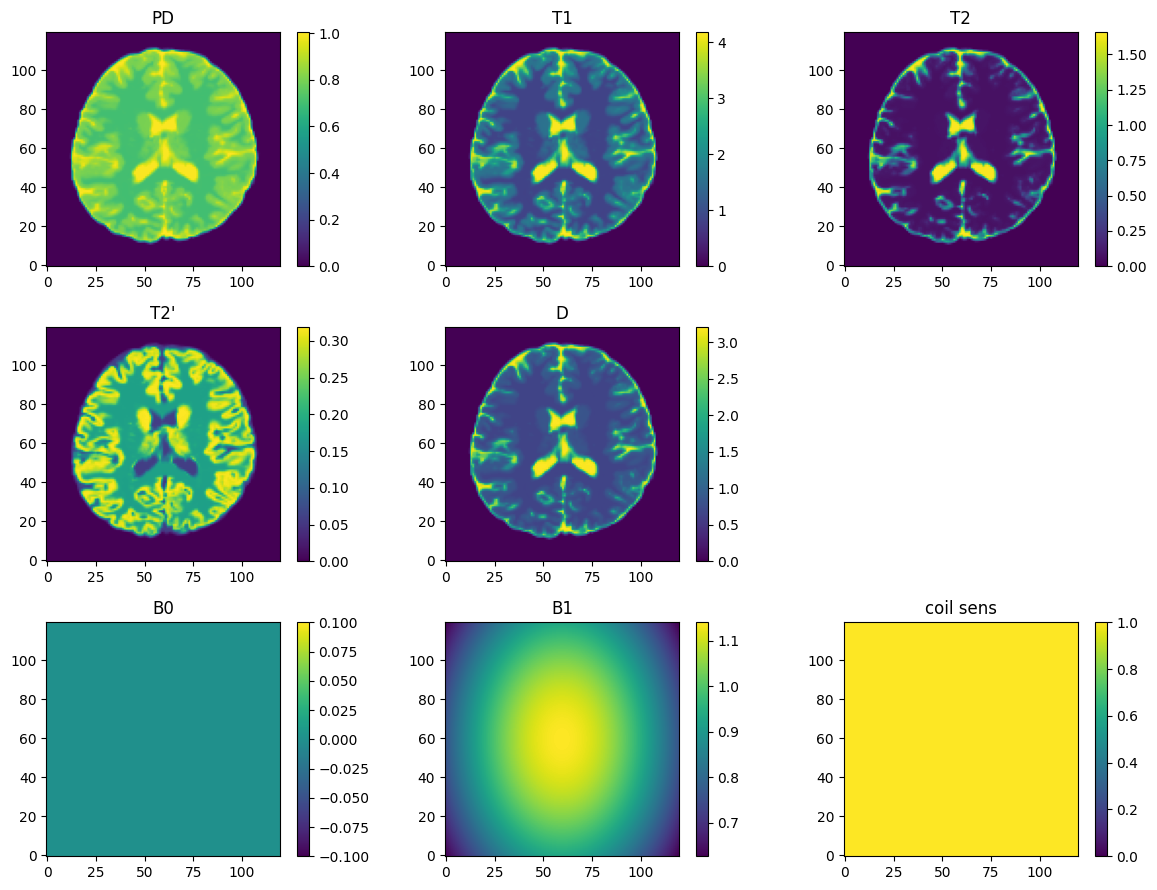

In [195]:
phantom_size = 120
phantom = mr0.VoxelGridPhantom.load("phantom/subject05_3T.npz")
print(phantom.PD.shape)
phantom = phantom.interpolate(phantom_size, phantom_size, 1)
data = phantom.build()
phantom.B0*=0
mask = torch.abs(phantom.PD)>1e-5
# # phantom.D=torch.ones_like(phantom.D)*5
# # phantom.T2dash=torch.ones_like(phantom.T2dash)*0.3
# phantom.B1 = torch.ones_like(phantom.B1)
phantom.plot()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.001769724 s
Compute Graph
Computing Graph: 0.11116991 s
Analyze Graph
Analyzing Graph: 0.000337519 s
Converting Rust -> Python: 0.005127488 s
<<<< Rust <<<<


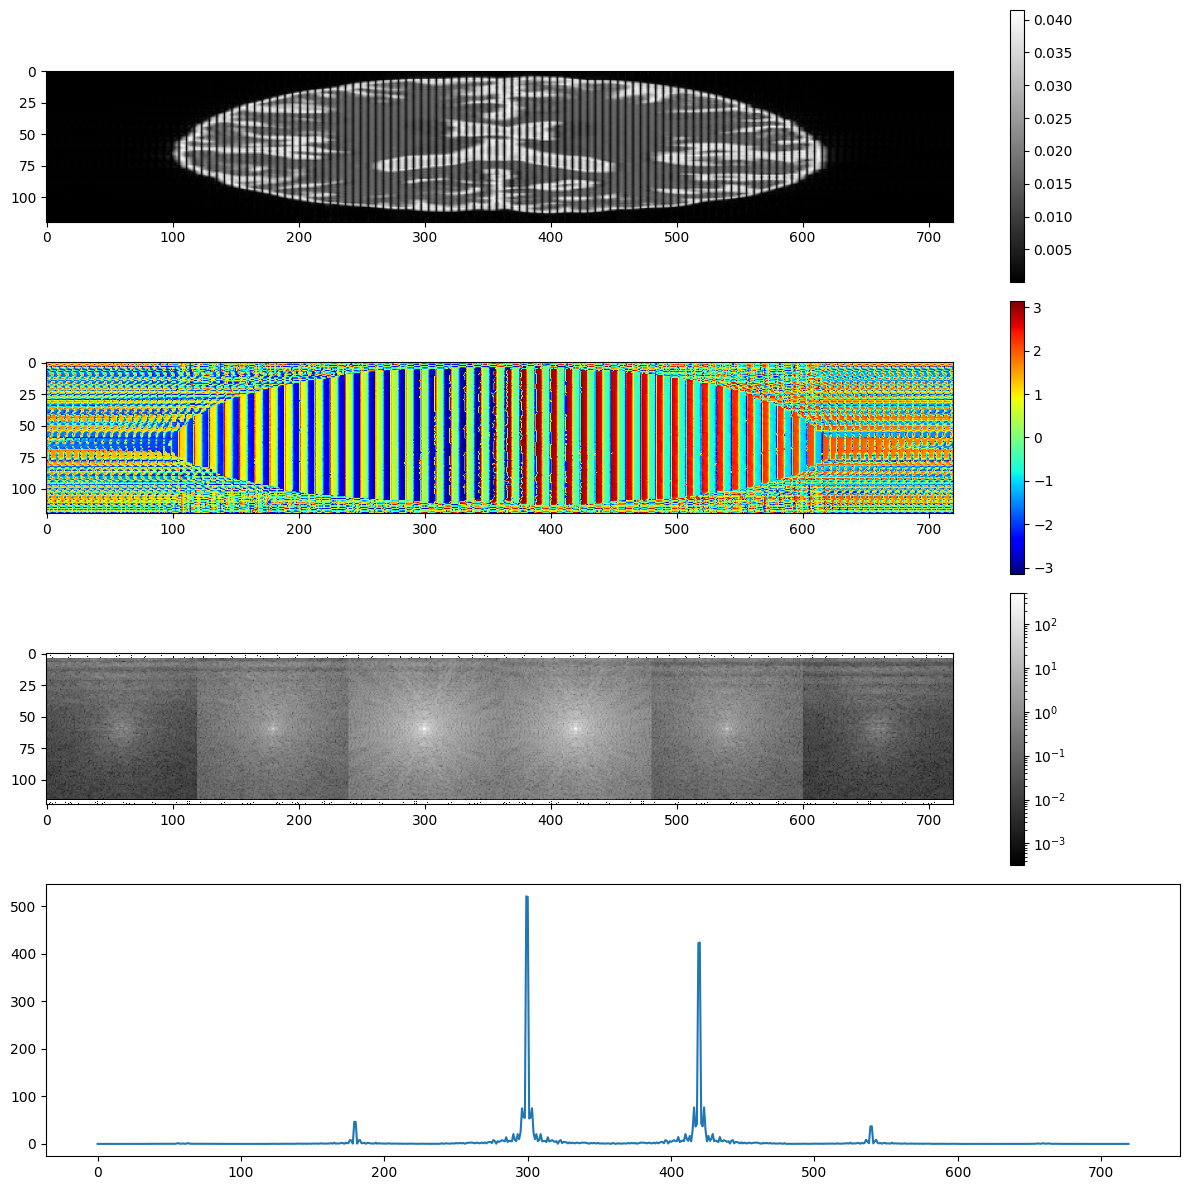

In [196]:
# seq_path = "seq/seq_p2n3.seq"
seq_path = "seq/seq_p2n3_spoiler.seq"
seq = pp.Sequence()
seq.read(seq_path)
signal, ksp = mr0.util.simulate(seq, phantom, accuracy=1e-15)

k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

plt.figure(figsize=(12, 12))
plt.subplot(4,1,1)
plt.imshow(np.abs(space.numpy()), cmap="gray")
plt.colorbar()

plt.subplot(4,1,2)
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())
plt.colorbar()

plt.subplot(4,1,4)
plt.plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

plt.tight_layout()

torch.Size([6, 120, 120])


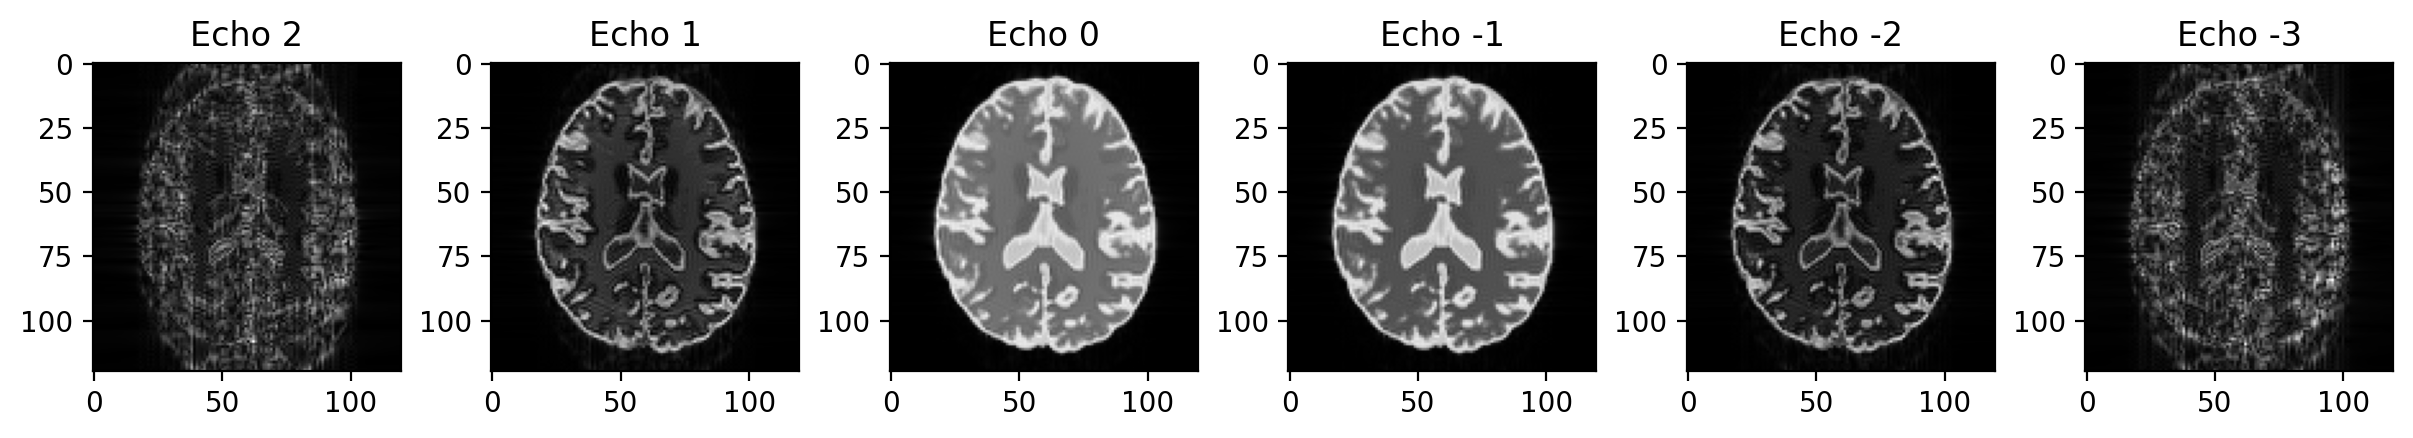

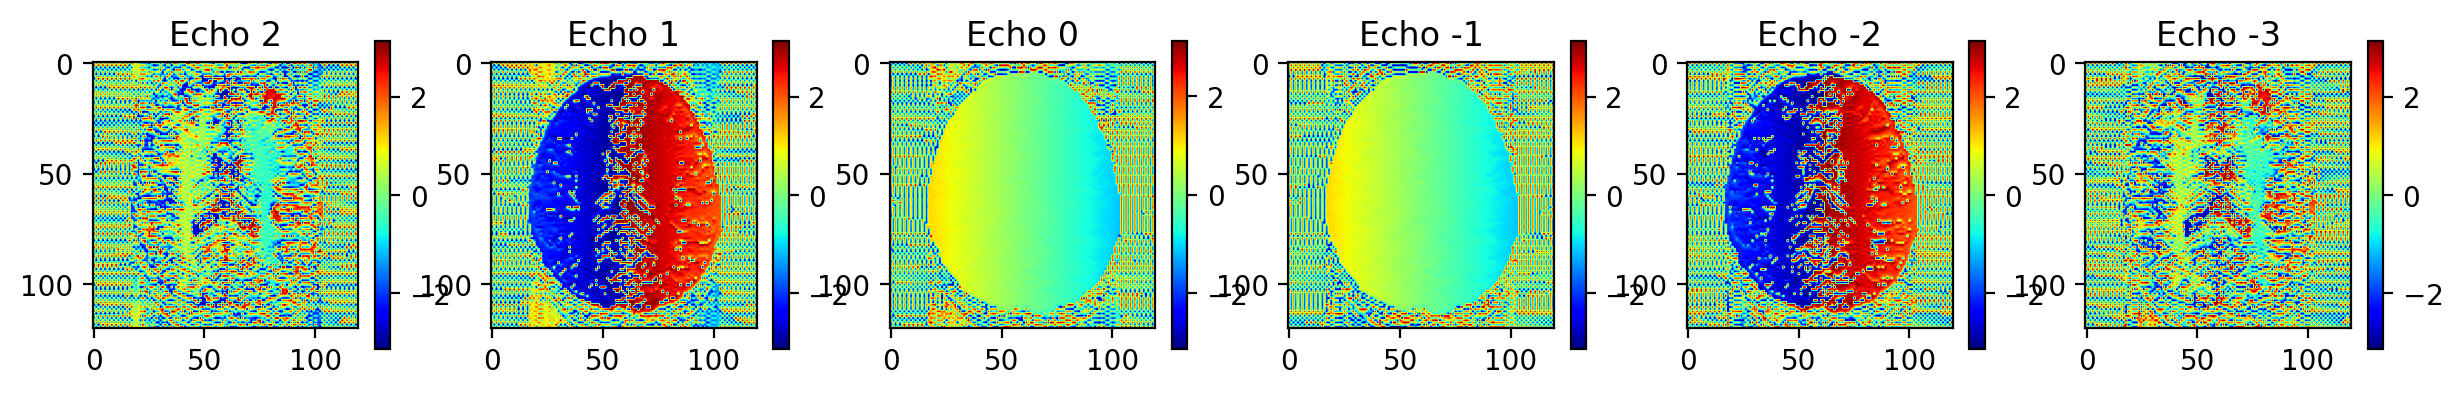

In [197]:
k_echoes = rearrange(k_space, "h (n w) -> n h w", n=6)
print(k_echoes.shape)

img_echoes = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(k_echoes, dim=(1,2)), dim=(1,2)), dim=(1,2))

plt.figure(figsize=(15, 2), dpi=200)
for idx,i in enumerate(np.linspace(2, -3 , 6,dtype=int)):
    plt.subplot(1,6,idx+1)
    plt.imshow(np.abs(img_echoes[idx].numpy()), cmap="gray")
    plt.title(f"Echo {i}")
plt.show()
plt.figure(figsize=(15, 2), dpi=200)
for idx,i in enumerate(np.linspace(2, -3 , 6,dtype=int)):
    plt.subplot(1,6,idx+1)
    plt.imshow(np.angle(img_echoes[idx].numpy()), cmap="jet")
    plt.title(f"Echo {i}")
    plt.colorbar()
plt.show()

In [198]:
class LinearModel(nn.Module):
    def __init__(self, img):
        super(LinearModel, self).__init__()
        self.lambd = nn.Parameter(torch.rand(img.shape[0],img.shape[1],1))
        self.mu = nn.Parameter(torch.rand(img.shape[0],img.shape[1],1))
    def forward(self, n):
        return self.lambd*n+self.mu

print(([2,*img_echoes.shape]))
linear = nn.Linear(6, 1)
x = torch.zeros((2,1,6))
print(linear(x).shape)

def fit_T2(img, n):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    assert img.shape[0]==n.shape[0]
    img_plus = rearrange(img[torch.argwhere(n>=0).squeeze()],"n h w -> h w n").to(device)
    img_minus = rearrange(img[torch.argwhere(n<0).squeeze()],"n h w -> h w n").to(device)
    n_plus = n[torch.argwhere(n>=0).squeeze()].to(device)
    n_minus = n[torch.argwhere(n<0).squeeze()].to(device)

    linear_plus = LinearModel(img_plus).to(device)
    linear_minus = LinearModel(img_minus).to(device)
    optimizer_plus = torch.optim.Adam(linear_plus.parameters(), lr=1e-3)
    optimizer_minus = torch.optim.Adam(linear_minus.parameters(), lr=1e-3)
    n_epoch = 5000

    lossplus_list = []
    lossminus_list = []
    print(linear_plus(n_plus).shape, img_plus.shape)
    for epoch in tqdm(range(n_epoch)):
        optimizer_plus.zero_grad()
        optimizer_minus.zero_grad()
        loss_plus = torch.mean(torch.abs(linear_plus(n_plus)-torch.abs(img_plus)))
        loss_minus = torch.mean(torch.abs(linear_minus(n_minus)-torch.abs(img_minus)))
        loss_plus.backward()
        loss_minus.backward()
        optimizer_plus.step()
        optimizer_minus.step()
        lossplus_list.append(loss_plus.item())
        lossminus_list.append(loss_minus.item())

    print(linear_plus(n_plus).shape, linear_minus(n_minus).shape)

    print(img_plus.shape, img_minus.shape)
    print(n_plus, n_minus)

    return linear_plus, linear_minus
    


n = torch.linspace(2,-3,6)

linear_plus,linear_minus = fit_T2(img_echoes,n)
# linear_plus,linear_minus = fit_T2(img_echoes[1:-1],n[1:-1])

[2, 6, 120, 120]
torch.Size([2, 1, 1])
torch.Size([120, 120, 3]) torch.Size([120, 120, 3])


100%|██████████| 5000/5000 [00:06<00:00, 786.73it/s]

torch.Size([120, 120, 3]) torch.Size([120, 120, 3])
torch.Size([120, 120, 3]) torch.Size([120, 120, 3])
tensor([2., 1., 0.], device='cuda:0') tensor([-1., -2., -3.], device='cuda:0')


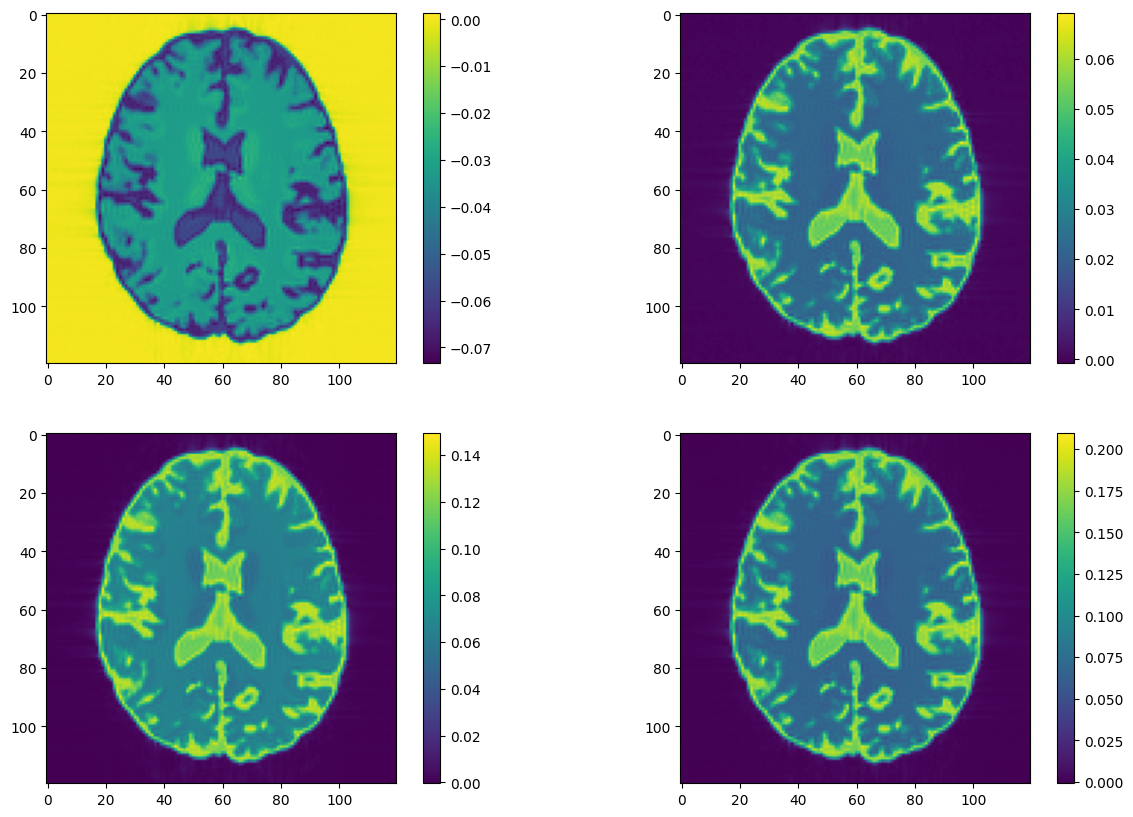

torch.Size([120, 120, 1])


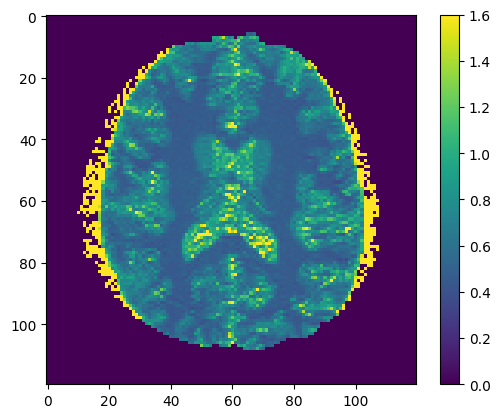

In [199]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.imshow((linear_plus.lambd.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow((linear_minus.lambd.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow((linear_plus.mu.cpu().detach().numpy()))
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow((linear_minus.mu.cpu().detach().numpy()))
plt.colorbar()
plt.show()
print((1/torch.abs(linear_plus.lambd.detach()+linear_minus.lambd.detach()).cpu()).shape)
# delta_TE = 0.00278
# delta_TE = 0.00735
delta_TE = 0.00234
plt.imshow((-2*delta_TE/(linear_plus.lambd.detach()+linear_minus.lambd.detach()).cpu())*torch.flip(rearrange(mask, "h w 1 -> w h 1"), dims=(0,1)))
plt.clim(0,1.6)
plt.colorbar()
plt.show()

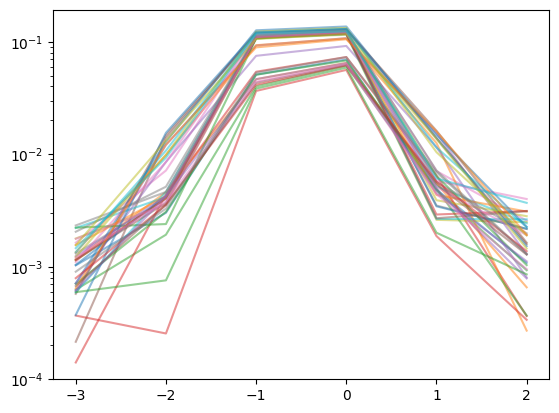

In [200]:
plt.plot(n,torch.abs(img_echoes[:,40:80,60]), alpha=0.5)
plt.yscale("log")
plt.show()

tensor([ 1.-1.7485e-07j, -1.+8.7423e-08j,  1.+0.0000e+00j,  1.+0.0000e+00j,
        -1.-8.7423e-08j,  1.-3.0199e-07j])


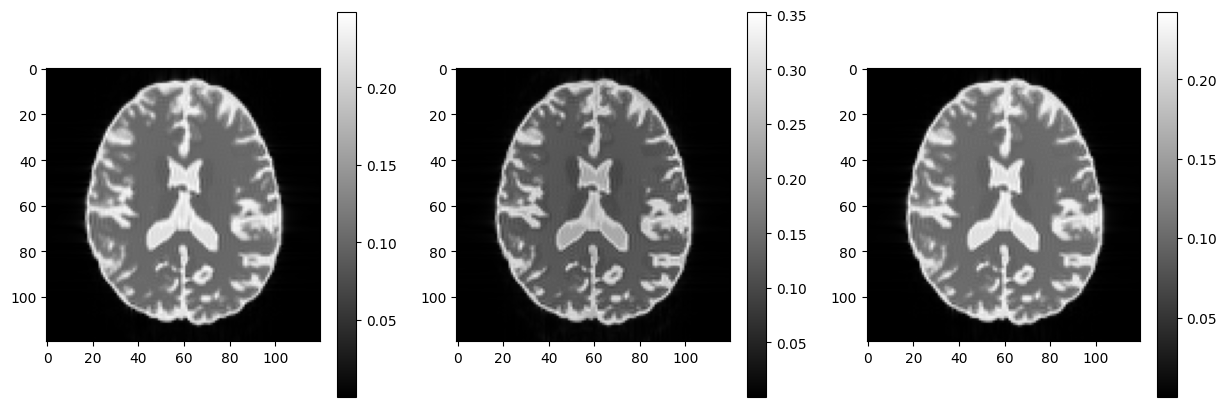

In [201]:
def u(n):
    return (n>=0).float()

phase = (u(n)-1)*torch.pi-torch.pi*n
print(torch.exp(1j*phase))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
# plt.imshow((torch.abs(img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.imshow(torch.abs((torch.abs(img_echoes)*torch.exp(1j*phase)[:,torch.newaxis,torch.newaxis]).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow((torch.abs(img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(torch.abs((img_echoes).sum(dim=0)).numpy(), cmap="gray")
plt.colorbar()